Import PyTorch

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [ ]:
transform = transforms.ToTensor()
batch_size = 8    #This means the GPU is going to handle 8 different examples at a time

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

classes = ('T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.33MB/s]


In [ ]:
train_iter = iter(trainset)

image, label = next(train_iter)

image.shape, label

#The label is 9, it should be a class of an Ankle boot

(torch.Size([1, 28, 28]), 9)

In [ ]:
torch.min(image).item(), torch.max(image).item()

(0.0, 1.0)

Ankle boot


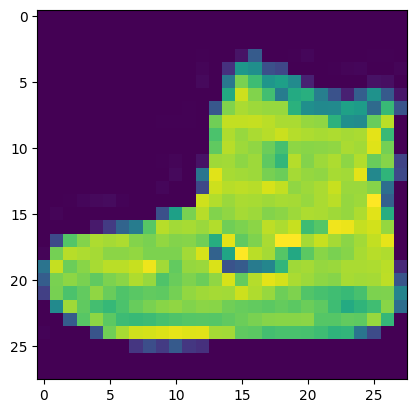

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

np_img = image.numpy()
print(classes[label])
plt.imshow(np_img.reshape((28, 28, 1)))

In [ ]:
len(trainset), len(testset)

(60000, 10000)

In [ ]:
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])
len(trainset), len(valset), len(testset)

(50000, 10000, 10000)

In [ ]:
print(f'Number of batches in the training set: {len(trainset) / batch_size}')
print(f'Number of batches in the validation set: {len(valset) / batch_size}')

Number of batches in the training set: 6250.0
Number of batches in the validation set: 1250.0


In [ ]:
type(trainset)

torch.utils.data.dataset.Subset

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=2)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=4096, out_features=1024)
        self.drop1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(in_features=1024, out_features=1024)
        self.drop2 = nn.Dropout(0.3)

        self.out = nn.Linear(in_features=1024, out_features=10)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.drop1(x)

        x = F.relu(self.fc2(x))
        x = self.drop2(x)

        x = self.out(x)

        return x

In [ ]:
net = NeuralNetwork()
net.to(device)

NeuralNetwork(
  (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=1024, out_features=10, bias=True)
)

In [ ]:
for i, data in enumerate(trainloader):
  inputs, labels = data[0].to(device), data[1].to(device)
  print(f'input shape: {inputs.shape}')
  print(f'after network shape: {net(inputs).shape}')
  break

input shape: torch.Size([8, 1, 28, 28])
after network shape: torch.Size([8, 10])


In [ ]:
num_params = 0
for x in net.parameters():
  num_params += len(torch.flatten(x))

print(f'Number of parameters: {num_params:,}')

Number of parameters: 8,536,074


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
def train_one_epoch():
  net.train(True)

  running_loss = 0.0
  running_accuracy = 0.0

  for batch_index, data in enumerate(trainloader):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs) #shape: [batch_size, 10]
    correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
    running_accuracy += correct / batch_size

    loss = criterion(outputs, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()

    if batch_index % 500 == 499:  #Will print every 500 batches
      avg_loss_across_batches = running_loss / 500
      avg_acc_across_batches = (running_accuracy / 500) * 100
      print(f'Batch {batch_index + 1}    Loss: {avg_loss_across_batches:0.3f}    Accuracy: {avg_acc_across_batches:0.1f}%')

      running_loss = 0.0
      running_accuracy = 0.0

  print()



In [ ]:
def validate_one_epoch():
  net.train(False)

  running_loss = 0.0
  running_accuracy = 0.0

  for i in enumerate(valloader):
    inputs, labels = data[0].to(device), data[1].to(device)

    with torch.no_grad():  #Since we are only validating the model, we don't need gradients to train it
      outputs = net(inputs)
      correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
      running_accuracy += correct / batch_size

      loss = criterion(outputs, labels) #This output is the average batch loss
      running_loss += loss.item()

  avg_loss_across_batches = running_loss / len(valloader)
  avg_acc_across_batches = (running_accuracy / len(valloader)) * 100

  print(f'Validation Loss: {avg_loss_across_batches:0.3f}     Validation Accuracy: {avg_acc_across_batches:0.1f}%')
  print('********************************************************')
  print()

In [ ]:
num_epochs = 10

for epoch_index in range(num_epochs):
  print(f'Epoch: {epoch_index + 1}\n')

  train_one_epoch()
  validate_one_epoch()

print('Training Complete')

Epoch: 1

Batch 500    Loss: 1.180    Accuracy: 54.9%
Batch 1000    Loss: 0.739    Accuracy: 72.4%
Batch 1500    Loss: 0.640    Accuracy: 75.8%
Batch 2000    Loss: 0.587    Accuracy: 77.0%
Batch 2500    Loss: 0.577    Accuracy: 78.3%
Batch 3000    Loss: 0.513    Accuracy: 80.8%
Batch 3500    Loss: 0.492    Accuracy: 81.6%
Batch 4000    Loss: 0.475    Accuracy: 82.6%
Batch 4500    Loss: 0.433    Accuracy: 84.0%
Batch 5000    Loss: 0.426    Accuracy: 84.6%
Batch 5500    Loss: 0.425    Accuracy: 84.0%
Batch 6000    Loss: 0.431    Accuracy: 83.8%

Validation Loss: 0.550     Validation Accuracy: 75.0%
********************************************************

Epoch: 2

Batch 500    Loss: 0.388    Accuracy: 85.8%
Batch 1000    Loss: 0.339    Accuracy: 87.4%
Batch 1500    Loss: 0.368    Accuracy: 86.2%
Batch 2000    Loss: 0.352    Accuracy: 86.6%
Batch 2500    Loss: 0.349    Accuracy: 87.4%
Batch 3000    Loss: 0.334    Accuracy: 88.0%
Batch 3500    Loss: 0.369    Accuracy: 87.1%
Batch 4000    